In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.listdir('/content/drive/My Drive/MICCAI_BraTS/2018')

['MICCAI_BraTS_2018_Data_Training.zip',
 'MICCAI_BraTS_2018_Data_Validation.zip',
 'train']

In [3]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/MICCAI_BraTS/2018/MICCAI_BraTS_2018_Data_Training.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [4]:
os.listdir('/content/HGG/Brats18_CBICA_ASN_1')

['Brats18_CBICA_ASN_1_seg.nii.gz',
 'Brats18_CBICA_ASN_1_t1.nii.gz',
 'Brats18_CBICA_ASN_1_flair.nii.gz',
 'Brats18_CBICA_ASN_1_t1ce.nii.gz',
 'Brats18_CBICA_ASN_1_t2.nii.gz']

In [5]:
!pip install nilearn

     |████████████████████████████████| 2.5MB 2.6MB/s 


In [6]:
import nibabel as nib
import nilearn as nil
from nilearn.plotting import view_img, glass_brain, plot_anat, plot_epi
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K

Using TensorFlow backend.


In [7]:
folder_hgg = '/content/HGG/'
patients_hgg = os.listdir(folder_hgg)

In [8]:
len(patients_hgg)

210

In [9]:
def make_folders():
    output_root = '/content/drive/My Drive/MICCAI_BraTS/2018/train/hgg/'
    
    d3 = os.path.join(output_root, '3D')
    d3_t1 = os.path.join(d3, 't1')
    d3_t1ce = os.path.join(d3, 't1ce')
    d3_t2 = os.path.join(d3, 't2')
    d3_flair = os.path.join(d3, 'flair')
    d3_mask = os.path.join(d3, 'mask')
    try:
        os.makedirs(d3_t1)
    except:
        pass
    try:
        os.makedirs(d3_t1ce)
    except:
        pass
    try:
        os.makedirs(d3_t2)
    except:
        pass
    try:
        os.makedirs(d3_flair)
    except:
        pass
    try:
        os.makedirs(d3_mask)
    except:
        pass

    d2 = os.path.join(output_root, '2D')
    d2_t1 = os.path.join(d2, 't1')
    d2_t1ce = os.path.join(d2, 't1ce')
    d2_t2 = os.path.join(d2, 't2')
    d2_flair = os.path.join(d2, 'flair')
    d2_mask = os.path.join(d2, 'mask')
    try:
        os.makedirs(d2_t1)
    except:
        pass
    try:
        os.makedirs(d2_t1ce)
    except:
        pass
    try:
        os.makedirs(d2_t2)
    except:
        pass
    try:
        os.makedirs(d2_flair)
    except:
        pass
    try:
        os.makedirs(d2_mask)
    except:
        pass

In [10]:
def get_images(root_folder, patients):

    make_folders()
    output_root_3D = '/content/drive/My Drive/MICCAI_BraTS/2018/train/hgg/3D/'
    output_root_2D = '/content/drive/My Drive/MICCAI_BraTS/2018/train/hgg/2D/'

    for member in patients:

        folder = root_folder+member

        t1_path = folder + '/' + member + '_t1.nii.gz'
        t1 = nib.load(t1_path)
        t1 = t1.get_fdata()
        t1 = (t1/t1.max())*255
        t1 = t1.astype(np.uint8)

        t1ce_path = folder + '/' + member + '_t1ce.nii.gz'
        t1ce = nib.load(t1ce_path)
        t1ce = t1ce.get_fdata()
        t1ce = (t1ce/t1ce.max())*255
        t1ce = t1ce.astype(np.uint8)

        t2_path = folder + '/' + member + '_t2.nii.gz'
        t2 = nib.load(t2_path)
        t2 = t2.get_fdata()
        t2 = (t2/t2.max())*255
        t2 = t2.astype(np.uint8)

        flair_path = folder + '/' + member + '_flair.nii.gz'
        flair = nib.load(flair_path)
        flair = flair.get_fdata()
        flair = (flair/flair.max())*255
        flair = flair.astype(np.uint8)

        mask_path = folder + '/' + member + '_seg.nii.gz'
        mask = nib.load(mask_path)
        mask = mask.get_fdata()
        mask = mask*50
        mask = mask.astype(np.uint8)

        for i in range(mask.shape[2]):
        
            gray_img_mask = mask[:,:,i]
        
            if(np.unique(gray_img_mask).shape[0] > 1):        

                t1_filename = os.path.join(output_root_2D+'t1', member+'_'+str(i)+'.png')
                t1ce_filename = os.path.join(output_root_2D+'t1ce', member+'_'+str(i)+'.png')
                t2_filename = os.path.join(output_root_2D+'t2', member+'_'+str(i)+'.png')
                flair_filename = os.path.join(output_root_2D+'flair', member+'_'+str(i)+'.png')
                mask_filename = os.path.join(output_root_2D+'mask', member+'_'+str(i)+'.png')

                cv2.imwrite(t1_filename, t1[:, :, i])
                cv2.imwrite(t1ce_filename, t1ce[:, :, i])
                cv2.imwrite(t2_filename, t2[:, :, i])
                cv2.imwrite(flair_filename, flair[:, :, i])
                cv2.imwrite(mask_filename, mask[:, :, i])

        shutil.move(t1_path, output_root_3D+'t1/'+member+'.nii.gz')
        shutil.move(t1ce_path, output_root_3D+'t1ce/'+member+'.nii.gz')
        shutil.move(t2_path, output_root_3D+'t2/'+member+'.nii.gz')
        shutil.move(flair_path, output_root_3D+'flair/'+member+'.nii.gz')
        shutil.move(mask_path, output_root_3D+'mask/'+member+'.nii.gz')

In [11]:
get_images(folder_hgg, patients_hgg)

# UNet for Segmentation of Whole Tumor from Flair Images

In [28]:
def transform_flair(img, label):
    img = img / 255
    
    label = tf.cast(tf.greater(label, 0), tf.int32)
    #label = tf.expand_dims(tf.cast(label, tf.int32), axis=2)
    #label = tf.concat(((-label)+1, label), axis=2)
    
    return img, label

In [13]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    parts = tf.where(tf.math.equal(parts, 'flair'), 'mask', parts)
    new_path = tf.strings.reduce_join(parts, separator='/')
    label = tf.io.read_file(new_path)
    label = tf.image.decode_png(label)
    return label

In [14]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = tf.image.decode_png(img)
  return img , label

In [35]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

In [16]:
list_flair = tf.data.Dataset.list_files('/content/drive/My Drive/MICCAI_BraTS/2018/train/hgg/2D/flair/*')

In [36]:
train_data_whole = list_flair.map(process_path)
train_data_whole = train_data_whole.map(transform_flair, num_parallel_calls=AUTO).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTO)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("SelectV2:0", shape=(None,), dtype=string)


Image shape:  (64, 240, 240, 1)
Label:  (64, 240, 240, 1)


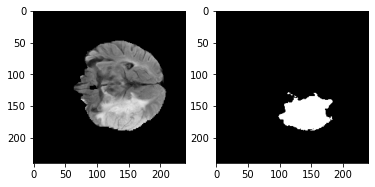

In [33]:
for image, label in train_data_whole.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy().shape)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image[0].numpy().reshape((240,240)), cmap='gray')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(label[0].numpy().reshape((240,240)), cmap='gray')

In [61]:
def UNet_whole():
    inputs = Input((240,240,1))
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (p1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (p2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (p3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c4)
    p4 = MaxPooling2D((2, 2)) (c4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c5)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (u6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c6)
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (u7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c7)
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (u8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c8)
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (u9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss_whole, metrics=[dice_coef_whole])

    return model

In [58]:
def dice_coef_whole(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''

    class_num = 1
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [59]:
def dice_coef_loss_whole(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef_whole(y_true, y_pred)

In [62]:
whole_model = UNet_whole()

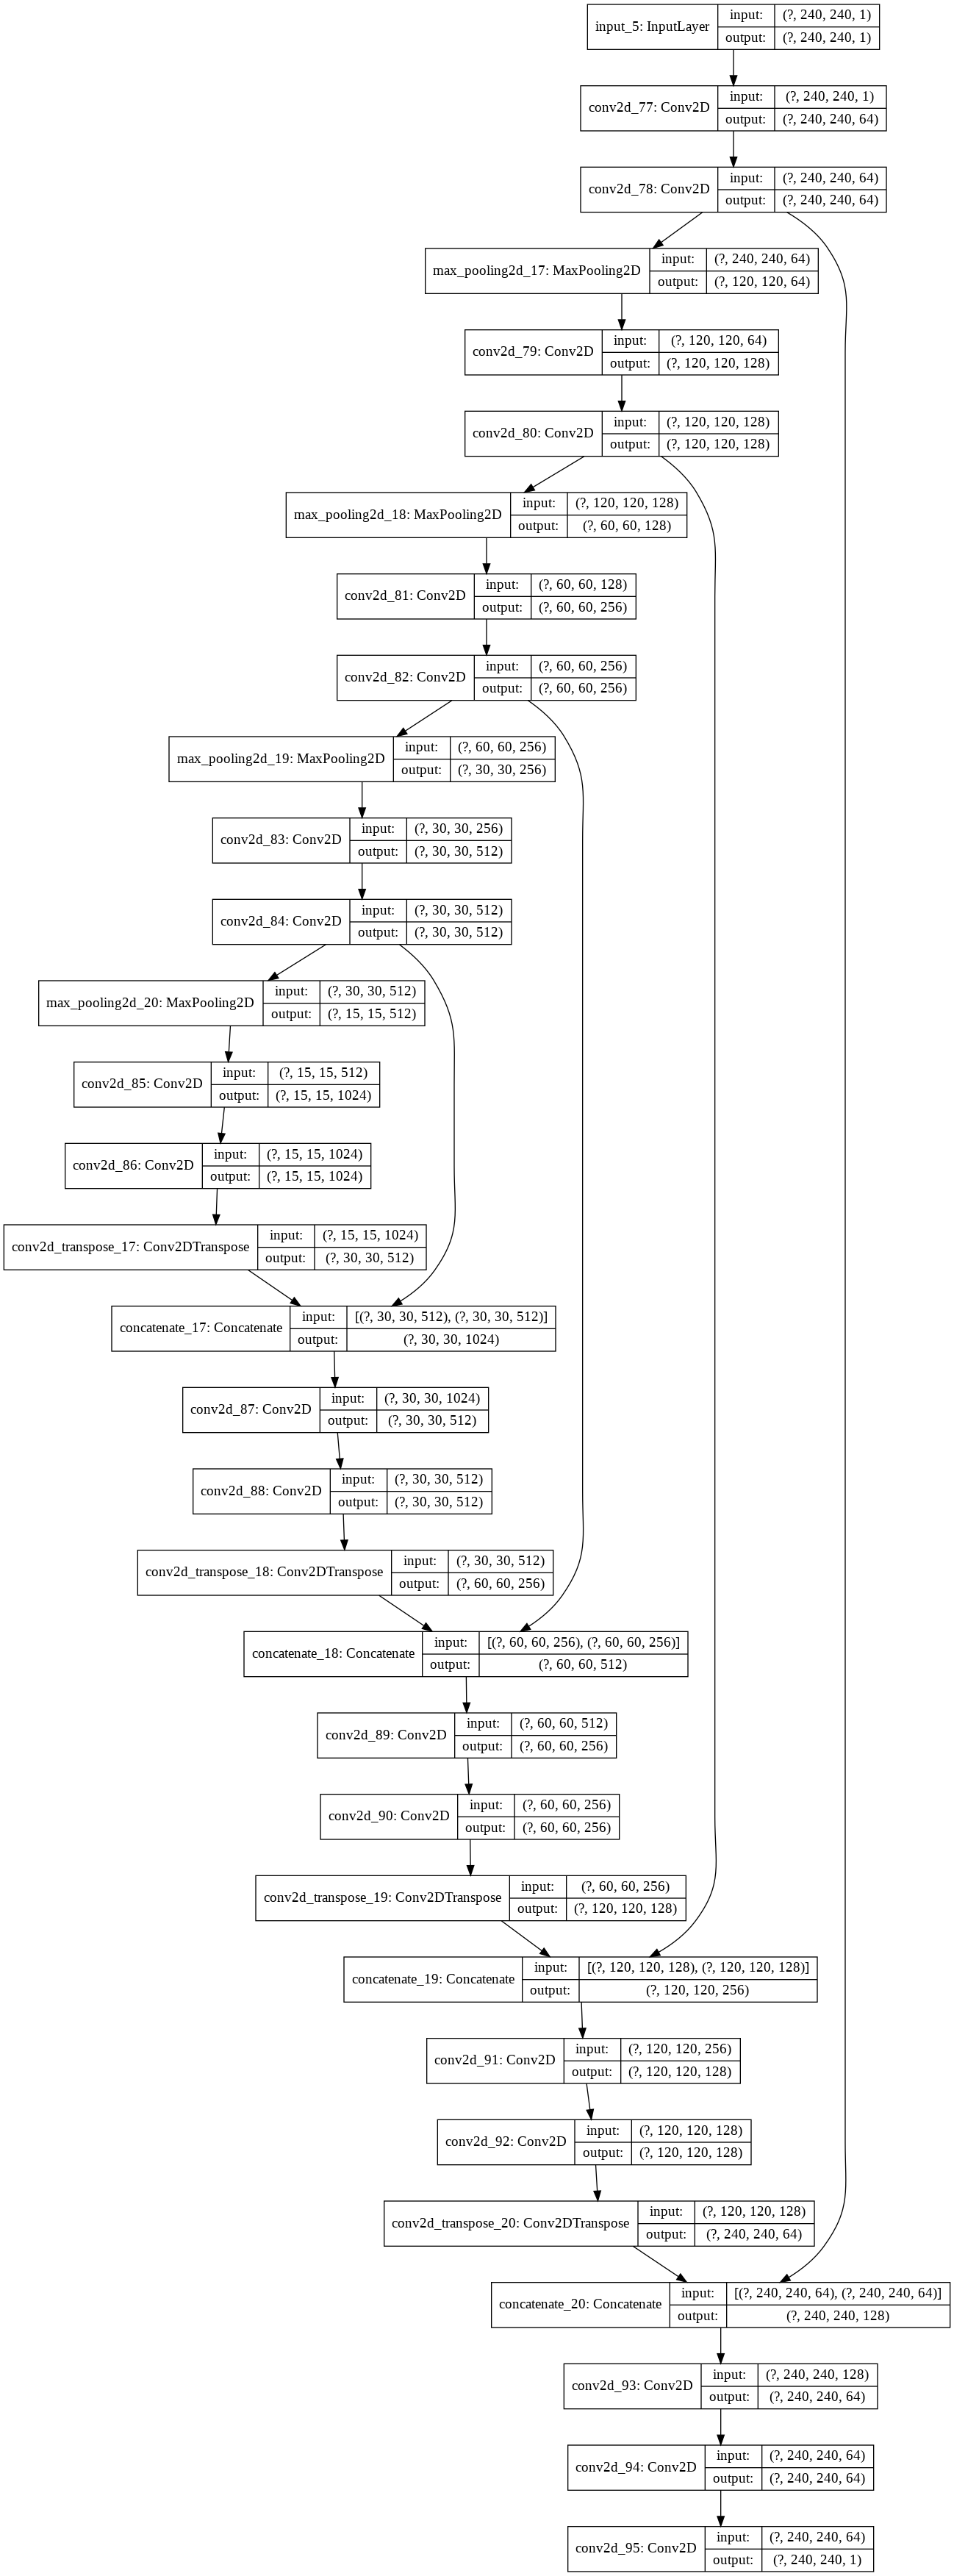

In [63]:
tf.keras.utils.plot_model(whole_model, show_shapes=True)

In [50]:
EPOCHS = 3

In [64]:
loss_tracker = []
for ep in range(EPOCHS):
    loss = 0
    steps = 0
    print(ep+1, '/', EPOCHS)
    for (abc, efg) in train_data_whole:
        
        history = whole_model.train_on_batch(abc, efg)
        loss += history[0]
        steps += 1
        print('Loss : ', history[0], ', Dice Coeff : ', history[1])
    loss_tracker.append(loss/steps)

1 / 3
Loss :  0.937674 , Dice Coeff :  0.06232599
Loss :  0.94537693 , Dice Coeff :  0.054623064
Loss :  0.9495519 , Dice Coeff :  0.05044813
Loss :  0.94086355 , Dice Coeff :  0.05913643
Loss :  0.94918394 , Dice Coeff :  0.05081604
Loss :  0.9322447 , Dice Coeff :  0.0677553
Loss :  0.9288933 , Dice Coeff :  0.0711067
Loss :  0.9211301 , Dice Coeff :  0.07886989
Loss :  0.9340678 , Dice Coeff :  0.06593223
Loss :  0.9304136 , Dice Coeff :  0.06958637
Loss :  0.93998295 , Dice Coeff :  0.06001706
Loss :  0.9234322 , Dice Coeff :  0.07656785
Loss :  0.8904122 , Dice Coeff :  0.10958779
Loss :  0.8774562 , Dice Coeff :  0.12254384
Loss :  0.8560747 , Dice Coeff :  0.1439253
Loss :  0.99338335 , Dice Coeff :  0.0066166446
Loss :  0.9745964 , Dice Coeff :  0.02540364
Loss :  0.76672256 , Dice Coeff :  0.23327743
Loss :  0.698516 , Dice Coeff :  0.30148402
Loss :  0.8578754 , Dice Coeff :  0.14212461
Loss :  0.637329 , Dice Coeff :  0.36267105
Loss :  0.7735504 , Dice Coeff :  0.22644961
L

In [65]:
whole_model.save('/content/drive/My Drive/MICCAI_BraTS/2018/unet_complete')

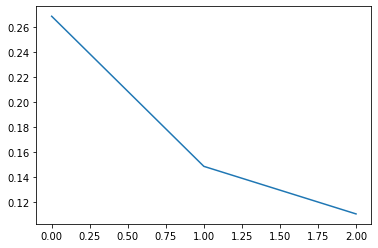

In [66]:
plt.plot(loss_tracker)

In [67]:
img, lab = next(iter(train_data_whole))
res = whole_model.predict_on_batch(img)

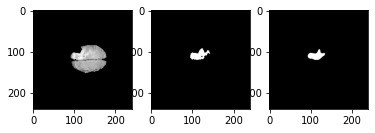

In [68]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img[20].numpy().reshape((240,240)), cmap='gray')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(lab[20].numpy().reshape((240,240)), cmap='gray')
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(res[20].reshape((240,240)), cmap='gray')

# UNet for Segmentation of all Categories

In [ ]:
def get_flair(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img)
    return img

In [ ]:
def get_t1(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    parts = tf.where(tf.math.equal(parts, 'flair'), 't1', parts)
    new_path = tf.strings.reduce_join(parts, separator='/')
    img = tf.io.read_file(new_path)
    img = tf.image.decode_png(img)
    return img

In [ ]:
def get_t1ce(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    parts = tf.where(tf.math.equal(parts, 'flair'), 't1ce', parts)
    new_path = tf.strings.reduce_join(parts, separator='/')
    img = tf.io.read_file(new_path)
    img = tf.image.decode_png(img)
    return img

In [ ]:
def get_t2(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    parts = tf.where(tf.math.equal(parts, 'flair'), 't2', parts)
    new_path = tf.strings.reduce_join(parts, separator='/')
    img = tf.io.read_file(new_path)
    img = tf.image.decode_png(img)
    return img

In [ ]:
def get_mask(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    parts = tf.where(tf.math.equal(parts, 'flair'), 'mask', parts)
    new_path = tf.strings.reduce_join(parts, separator='/')
    img = tf.io.read_file(new_path)
    img = tf.image.decode_png(img)
    return img

In [ ]:
def get_img_from_path(file_path):
  label = get_mask(file_path)
  t1 = get_t1(file_path)
  t1ce = get_t1ce(file_path)
  t2 = get_t2(file_path)
  flair = get_flair(file_path)
  img = tf.concat([flair, t1, t1ce, t2])
  return img , label

In [ ]:
def process_images(img, label):
    img = img/255
    bg =  tf.cast(tf.equal(label, 0), tf.int32)
    lab1 = tf.cast(tf.equal(label, 50), tf.int32)
    lab2 = tf.cast(tf.equal(label, 100), tf.int32)
    lab4 = tf.cast(tf.equal(label, 200), tf.int32)
    lab = tf.concat([bg, lab1, lab2, lab4])
    return img , lab

In [ ]:
train_data = list_files.map(get_img_from_path)
train_data = train_data.map(process_images, num_parallel_calls=AUTO).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTO)

In [ ]:
def UNet():
    inputs = Input((240,240,4))  # each modality is a channel
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D((2, 2)) (c4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9) # one channel for each of the 4 labels (0,50,100,200)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
def dice_coef_whole(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''

    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [ ]:
def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)